In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import RFutils
import scipy.signal as signal
import cf_xarray as cfxr
from datetime import timedelta

from scipy.signal import savgol_filter
import csv

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
model_conv_dict = RFutils.model_1pctCO2_dict

conv_id = 'EnROADS Base'
hist_id = 'historical'
train_id = ['1pctCO2']
print(f'Load and convolve {conv_id} run...')

feedback_cooling = pd.read_csv('../EnROADS_Data/Feedback_Cooling.csv',usecols=[0,1])
feedback_cooling = feedback_cooling.rename(columns={'Time (Year)':'year','Feedback Cooling':'Feedback Cooling'})
RF_total = pd.read_csv('../EnROADS_Data/RF.csv')
RF_profile_EnROADS = pd.DataFrame(RF_total['Total Radiative Forcing'])
RF_profile_EnROADS = RF_profile_EnROADS.rename(columns={'Total Radiative Forcing': 'RF'})
RF_profile_EnROADS = RF_profile_EnROADS.set_index(feedback_cooling['year'])
RF_profile_EnROADS = RF_profile_EnROADS.to_xarray()

years = []
RF_data = []
with open('../EnROADS_Data/ERFs_Miller.txt', "r") as file:
    i = 0
    for row in csv.reader(file):
        if i < 6:
            i+=1
            continue
        vals = row[0].split()
        if int(vals[0]) < 1990:
            years.append(int(vals[0]))
            RF_data.append(float(vals[1]))
            #print(vals)
        else:
            break
            
RF_profile_Miller_hist = pd.DataFrame({'year':years,'RF': RF_data})
RF_profile_Miller_hist = RF_profile_Miller_hist.set_index('year')
RF_profile_Miller_hist = RF_profile_Miller_hist.to_xarray()

RF_profile_combine = {}
for m in model_conv_dict.keys():
    RF_profile_combine[m] = xr.concat([RF_profile_Miller_hist,RF_profile_EnROADS],dim='year')
    
RF_ds = RFutils.concat_multirun(RF_profile_combine, 'model')

Load and convolve EnROADS Base run...


In [3]:
tas_EnROADS = pd.read_csv(f'../Example_Data/dT_EnROADS_Base.csv',header=0)
tas_EnROADS = tas_EnROADS.rename(columns={'Baseline':'tas','Year':'year'})
tas_EnROADS = tas_EnROADS.set_index(tas_EnROADS['year'])
tas_EnROADS = tas_EnROADS.to_xarray()

tas_hist = pd.read_csv(f'../EnROADS_Data/Daten-Table 1.csv',skiprows=11,usecols=[1,2])
tas_hist = tas_hist.rename(columns={'Jahr\n(Year)':'year',
                                    'Temperatur-Abweichung vom langjährigen Mittel 1850-1900\n(Temperature deviation from the long-term average 1850-1900)':'tas'})
tas_hist = tas_hist[tas_hist['year'] < 2000]
tas_hist = tas_hist.set_index(tas_hist['year'])
tas_hist = tas_hist.drop(columns=['year'])
tas_hist = tas_hist.to_xarray()

tas_combined = {}
for m in model_conv_dict.keys():
    tas_combined[m] = xr.concat([tas_hist,tas_EnROADS],dim='year')
tas_ds = RFutils.concat_multirun(tas_combined, 'model')

In [4]:
G_ds_dict = {}
for train in train_id:
    G_ds_path = f'../Outputs/RF_Outputs/G_{train}_F_all_ds.nc4'
    G_ds = xr.open_dataset(G_ds_path)['__xarray_dataarray_variable__']
    G_ds.name = 'G[tas]'
    G_ds = G_ds.rename({'year':'s'})
    G_ds_dict[train] = G_ds
    
G_ds = RFutils.concat_multirun(G_ds_dict, 'train_id')

In [5]:
conv_mean_ds = RFutils.convolve_exp(G_ds, RF_ds, model_conv_dict, train_id, conv_mean = True)
conv_ds = RFutils.convolve_exp(G_ds, RF_ds, model_conv_dict, train_id, conv_mean = False)

Convolving ACCESS-CM2 for Global Mean
Convolving ACCESS-ESM1 for Global Mean
Convolving CAMS for Global Mean
Convolving CanESM for Global Mean
Convolving INM-CM4 for Global Mean
Convolving INM-CM5 for Global Mean
Convolving MIROC for Global Mean
Convolving MRI for Global Mean
Convolving NorESM-LM for Global Mean
Convolving ACCESS-CM2 Spatially
Convolving ACCESS-ESM1 Spatially
Convolving CAMS Spatially
Convolving CanESM Spatially
Convolving INM-CM4 Spatially
Convolving INM-CM5 Spatially
Convolving MIROC Spatially
Convolving MRI Spatially
Convolving NorESM-LM Spatially


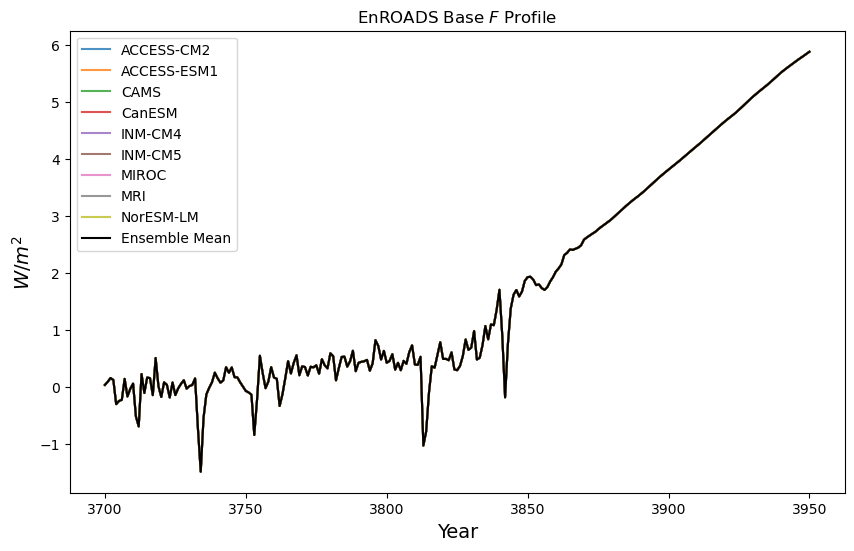

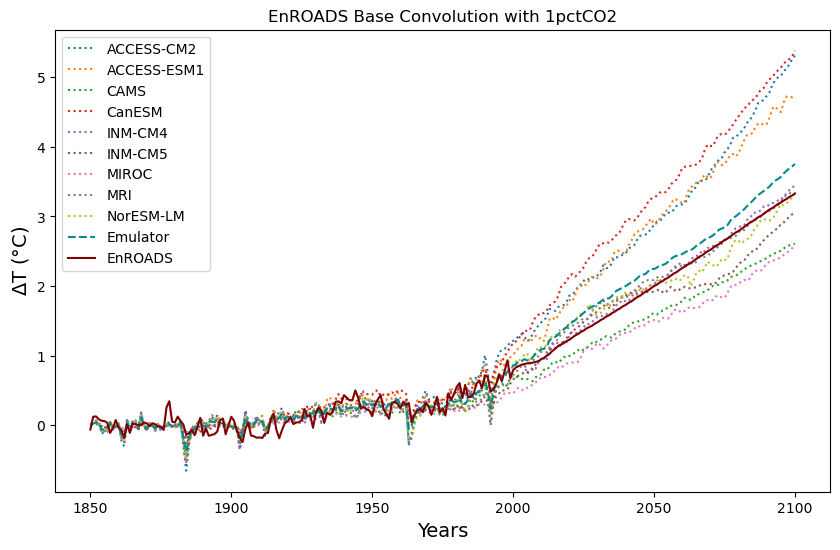

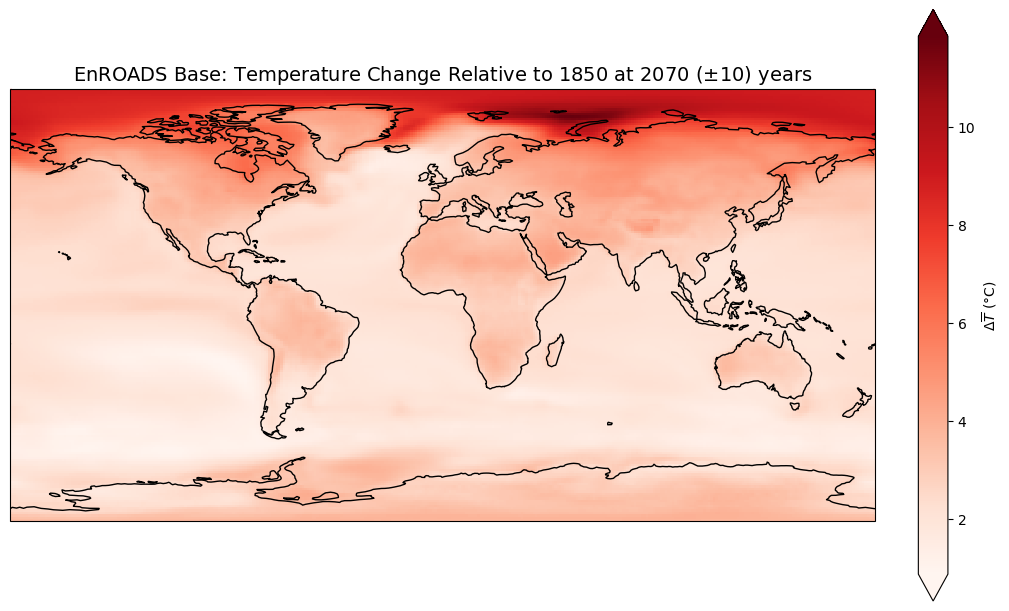

In [6]:
model_color = RFutils.model_color
type_color = RFutils.type_color
RFutils.plot_RF_profile(RF_ds, conv_id, model_color, save_fig = True)
RFutils.plot_conv_enROADS(train_id, conv_id, conv_mean_ds, tas_combined, type_color, save_fig = True)
RFutils.plot_dif_map(conv_ds, ds_dif = None, plot_yr = 220, yr_dif = 10, conv_id = conv_id, dif = False, save_fig = True)

In [31]:
RMSE, MAE, bias = RFutils.calc_error_metrics_EnROADS(tas_ds, conv_mean_ds)
print(RMSE,MAE,bias)

5.481361081932907 0.1505313403090575 0.09016268980927808
